#  <font style="color:blue">Instance Segmentation using Mask RCNN</font>

In this session, we will learn how to train instance segmentation model using detectron2's pretrained Mask RCNN model. First, lets understand instance segmentation. Instance segmentation task is the labelling of each foreground pixel with object and instance.

**Instant Segmentation -> Object Detection + Semantic Segmentation**

Instance Segmentation is challenging because it requires the correct detection of all objects in an image while also precisely segmenting each instance. It therefore combines elements from the classical computer vision tasks of object detection, where the goal is to classify individual objects and localize each using a bounding box, and semantic segmentation, where the goal is to classify each pixel into a fixed set of categories without differentiating object instances.

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w11-instance-egmentation.png" width=1000>

#  <font style="color:green">1. Model</font>

Now, lets understand how Mask RCNN performs instance segmentation. **Mask RCNN** extends Faster R-CNN by adding a branch for predicting an object mask in parallel with the existing branch for bounding box recognition.

In brief, **Faster RCNN**  consists of two stages. The first stage, called a Region Proposal Network (RPN),
proposes candidate object bounding boxes. The second stage, which is in essence Fast R-CNN, extracts features using RoIPool from each candidate box and performs classification and bounding-box regression. Mask R-CNN adopts the same two-stage procedure, with an identical first stage (which is RPN). In the second stage, in parallel to predicting the class and box offset, Mask R-CNN also outputs a binary mask for each RoI.

Lets see how we can train custom object using detectron2 and pretrained Mask RCNN model. We will see how **backpacks** can be detected and segmented in videos using our trained model.

# <font style="color:green">2. Dataset Ingestion</font>

We will use OpenImages dataset to download backpack images, masks and their corresponding labels. The detectron2's standard dataset format is COCO format so here, we will show how to convert the OpenImages dataset to COCO format.

## <font style="color:green">2.1. Introduction to OpenImages</font>


**[Go to OpenImages](https://storage.googleapis.com/openimages/web/index.html)**

Google has introduced OpenImages, an open source dataset containing `~ 9 million` images annotated with labels spanning thousands of object categories. In `2018`, it has released OpenImages `V4` which included `15.4M` bounding-boxes for `600` object categories, making it the largest existing dataset with object location annotations, as well as over `300k` visual relationship annotations. Recently, it has released Open Images `V5`, which adds segmentation masks to the set of annotations.

Open Images `V5` features segmentation masks for `2.8 million` object instances in `350` categories. Unlike bounding-boxes, which only identify regions in which an object is located, segmentation masks mark the outline of objects, characterizing their spatial extent to a much higher level of detail. Importantly, these masks cover a broader range of object categories and a larger total number of instances than any previous dataset.

**For instance segmentation, COCO format will have json containing all the images, segmentations information. So, we will also show how this json can be created.**

## <font style="color:green">2.2. Download Mask Images</font>

**There are two methods to prepare mask images:**

- (a) Download the prepared mask images for the backpack class.


- (b) Download the class description file, and all mask images then filter mask images for the backpack.

Although the first method is the easiest one, however, it is recommended to go through the second method as well.

### <font style="color:green">2.2.a. Prepared Mask Images for Backpacks</font>

**You can download prepared masks data from this [link](https://www.dropbox.com/s/uj57mbztvyg5tiq/backpack-masks.zip?dl=1) and unzip it.**


**You can also download and unzip data by running cells.**

**Create the root directory.**

In [1]:
import os
from tqdm import tqdm

# create a data root
data_root = 'data'

os.makedirs(data_root, exist_ok=True)

**Function to download using URL.**

In [2]:
import urllib

def download(url, filepath):
    
    response = urllib.request.urlretrieve(url, filepath)
    return response

**Let's declare download_unzip flag, make it true when we have to download the data else make it false.**

In [3]:
# make it true to download all required data
download_unzip = False

In [4]:
mask_backpacks_url = 'https://www.dropbox.com/s/uj57mbztvyg5tiq/backpack-masks.zip?dl=1'
mask_backpacks_zip_path = os.path.join(data_root, 'backpack-masks.zip')

if download_unzip:
    download(mask_backpacks_url, mask_backpacks_zip_path)

**Function for unzips a zip-file.**

In [5]:
import zipfile

def unzip(zip_filepath, target_dir):
    with zipfile.ZipFile(zip_filepath,'r') as zip_file:
        zip_file.extractall(target_dir)
    return

In [6]:
backpacks_unzip_path = data_root

if download_unzip:
    unzip(mask_backpacks_zip_path, backpacks_unzip_path)

### <font style="color:green">2.2.b. Download and Filter</font>

We have to download mask images for backpacks. First, we need to find whether the mask for **backpacks** is available or not. If it is available, what is its ClassId? To check this, we need to download `class-descriptions-segmentable.csv`.

**[Download class-descriptions-segmentable.csv](https://www.dropbox.com/s/wtl8s3ofy45ezgl/class-descriptions-segmentable.csv?dl=1)**


**You can also download by running the below cell.**

In [7]:
csv_url = 'https://www.dropbox.com/s/wtl8s3ofy45ezgl/class-descriptions-segmentable.csv?dl=1'
class_descriptions_file_path = os.path.join(data_root, 'class-descriptions-segmentable.csv')

if download_unzip:
    download(csv_url, class_descriptions_file_path)

**Let's find classId for backpacks.**

In [8]:
def find_class_id(classname, csv_path='class-descriptions-segmentable.csv'):
    with open(csv_path, 'r') as f:
        for line in f:
            clss = line.rstrip().split(",")

            if clss[1] == classname:
                return clss[0]
    return None

In [9]:
class_name = 'Backpack'

backpack_class_id = find_class_id(class_name, class_descriptions_file_path)
print('Class ID of Backpack: {}'.format(backpack_class_id))

Class ID of Backpack: /m/01940j


From the above file, we can select any class of our choice and note the classid to get the images and masks belonging to the selected class. Here, the selected class **Backpack** classID is **`m01940j`**.

We will download mask images from segmentation train image folders of **OpenImages V6**. Then collect the backpack masks from all the folders into single folder.

#### Download Links
https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip

https://storage.googleapis.com/openimages/v5/train-masks/train-masks-1.zip

https://storage.googleapis.com/openimages/v5/train-masks/train-masks-2.zip

https://storage.googleapis.com/openimages/v5/train-masks/train-masks-3.zip


We can download the raw mask data from the above links and unzip it.

You can also download and unzip data by running the below code cell.

**Download `train-masks-*.zip` and `unzip` it.**

In [10]:
mask_url = 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-{}.zip'
mask_filepath = os.path.join(data_root, 'train-masks-{}.zip')

unzip_path = os.path.join(data_root, 'train-masks-{}')

if download_unzip:
    for i in range(4):
        res = download(mask_url.format(i), mask_filepath.format(i))
        print(res)
        unzip(mask_filepath.format(i), unzip_path.format(i))
        print('File {} unzipped to {}'.format(mask_filepath.format(i), unzip_path.format(i)))

#### Filter backpacks mask images

We can also download more directories similar to the above. Once the mask folders are downloaded, lets select the backpack masks among all the mask folders and store it in a separate folder `backpack-masks`.

In [11]:
import shutil

def copy_mask_for_classid(classid, source_dir, target_dir):
    
    os.makedirs(target_dir, exist_ok=True)
        
    for img_file in os.listdir(source_dir):
        if classid in img_file:
            file_path = os.path.join(source_dir, img_file)
            shutil.copy(file_path, target_dir)
    return

In [12]:
backpack_mask_dir = os.path.join(data_root, 'backpack-masks')

if download_unzip:
    for i in range(4):
        copy_mask_for_classid(backpack_class_id.replace('/', ''), unzip_path.format(i), backpack_mask_dir)

## <font style="color:green">2.3. Download Annotations File</font>

We will have to download the annotation file for segmentation.

**[Download the annotation file](https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv).**

You can also download by executing the below cell. 

In [13]:
train_seg_url = 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv'
train_seg_csv_path = os.path.join(data_root, 'train-annotations-object-segmentation.csv')

if download_unzip:
    download(train_seg_url, train_seg_csv_path)

## <font style="color:green">2.4. Download Images</font>

We have to download only those images that have masks and annotations. 

The mask image files path are in the format of `imageID_classID_maskID.png`. Using the `imageIDs`, we will download the images using `s3`.

**Let's write a function to get `imageId` form the mask filename.**

In [14]:
def get_imageid_from_masks(mask_dir_path):
    
    ids_list = os.listdir(mask_dir_path)
    img_ids = []

    for idl in ids_list:
        t = idl.split("_")[0]
        img_ids.append(t)

    return set(img_ids)

**Let's write a function to get class annotations.**

In [15]:
import csv

def get_class_annotations(classes_list, class_descriptions_csv, annotations_csv):
    #list of selected classes
    classes = classes_list

    #Create dict with className to classId mapping
    with open(class_descriptions_csv, mode='r') as infile:
        reader = csv.reader(infile)
        dict_list = {rows[1]:rows[0] for rows in reader}
    
    csvreader = open(annotations_csv, "r")
    class_annotations = {}
    
    for ind in range(0, len(classes)):
        class_name = classes[ind]
        class_annotations[class_name] = []
        print('Class {}: {}'.format(ind, class_name))

        ##Select the annotations with backpack classID
        for line in csvreader:
            if dict_list[class_name] in line:
                class_annotations[class_name].append(line.rstrip())
                
    return class_annotations

Now, we have a function to get image Ids and annotations. But we do not have images. Let's write a function to download images using image Ids and annotations.

We have to download images from S3-bucket (AWS storage). Downloading files from s3 requires an AWS-CLI app or boto3 python package.  In the function, we will use the AWS-CLI app. 

### Check if AWS already Installed

Run the following command in **`CLI`** to check if AWS already installed: 
```
aws --version
```
Running this command should have the output similar to the following:
```
aws-cli/2.0.13 Python/3.7.3 Linux/5.3.0-51-generic botocore/2.0.0dev17
```

If not, you have to install AWS:

- [Install AWS CLI MacOS](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-mac.html)


- [Install AWS CLI Linux](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-linux.html)


- [Install AWS CLI Windows](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-windows.html)

In [16]:
import subprocess

def download_images_for_a_class(annotations, class_name, mask_dir_path, download_dir):
    #Create directory for downloading images

    os.makedirs(download_dir, exist_ok=True)
        
    class_annotations = annotations[class_name]
    total_annotations = len(class_annotations)
    image_id_set = get_imageid_from_masks(mask_dir_path)
    print('Number of unique IDs: {}'.format(len(image_id_set)))

    for line in class_annotations[0:total_annotations]:
        line_parts = line.split(',')
        image_id = line_parts[1]

        if image_id not in image_id_set:
            continue
            
        image_url = 's3://open-images-dataset/train/{}.jpg'.format(image_id)
        # print(image_url)
        download_path = os.path.join(download_dir, '{}.jpg'.format(image_id))
        subprocess.run(['aws', 's3', '--no-sign-request', '--only-show-errors', 'cp', image_url, download_path])
    
    return

From the `train-annotations-object-segmentation.csv`, all the backpack records are collected. These records are used for downloading the images using imageID from s3-bucket and also for grouping all the segmentation boxes belonging to the same image based on ImageID key. 

In [17]:
annotations = get_class_annotations(['Backpack'], class_descriptions_file_path, train_seg_csv_path)

print('Total number of annotations: {}'.format(len(annotations['Backpack'])))

Class 0: Backpack
Total number of annotations: 1082


In [18]:
backpack_image_dir = os.path.join(data_root, 'backpack-images')

if download_unzip:
    download_images_for_a_class(annotations, 'Backpack', backpack_mask_dir, backpack_image_dir)

# <font style="color:green">3. Data Preparation for Training</font>

- We have a total of 329 training images. Data should be split into the train and validation set.


- We need data in the COCO JSON format.


## <font style="color:green">3.1. Split Data into Train and Validation</font>

**Let's write a function to split data into train and validation in a `9:1` ratio.**

In [19]:
def split_train_validation(data_dir_path):
    
    img_filenames = os.listdir(data_dir_path)
    train = []
    val = []
    for i, img_file in enumerate(img_filenames):
        if i%10 == 0:
            val.append(img_file)
        else:
            train.append(img_file)
            
    print('Number of training samples: {}'.format(len(train)))
    print('Number of validation samples: {}'.format(len(val)))
    
    return train, val

In [20]:
train_images, val_images = split_train_validation(backpack_image_dir)

Number of training samples: 296
Number of validation samples: 33


## <font style="color:green">3.2. Generate COCO formatted JSON</font>

**Sample of COCO JSON format:**

```
{
    "images": {"file_name": imageID + ".jpg",
               "height": imageHeight,
               "width": imageWidth,
               "id": imageID
              },
    "categories": { "supercategory": "object",
                    "id": classID,
                    "name": className
                  },
    "annotations": { "segmentation": contourPts,
                     "iscrowd": 0,
                     "image_id": imageID,
                     "bbox": bounding box coordinates(XYWH),
                     "category_id": classID,
                     "id": boxID
                   }
}
```

We will get `contourPts` form mask images and `bounding box coordinates(XYWH)` from annotations.


In [21]:
from collections import defaultdict

def get_all_annotations_for_each_image(annotations, mask_dir_path, class_name, class_index):
    
    class_annotations = annotations[class_name]
    annotations_count = len(class_annotations)
    image_id_set = get_imageid_from_masks(mask_dir_path)
    
    #OpenImages Annotation Format
    #MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks

    boxes = defaultdict(list)

    for line in class_annotations[0:annotations_count]:
        line_parts = line.split(',')

        ##Select annotations from those images whose masks we have downloaded
        if line_parts[1] not in image_id_set:
            continue

        mask_path = line_parts[0]
        image_id = line_parts[1]

        xmin = line_parts[4]
        xmax = line_parts[5]
        ymin = line_parts[6]
        ymax = line_parts[7]
        bbox_id = line_parts[3]

        #store annotations per image based on imageID
        
        dic = {
            'mask_path': mask_path,
            'class': str(class_index),
            'bbox': [xmin, xmax, ymin, ymax],
            'box_id': bbox_id
        }
        
        boxes[image_id].append(dic)
        
    return boxes

In [22]:
backpack_boxes = get_all_annotations_for_each_image(annotations, backpack_mask_dir, 'Backpack', 1)

### Contour Calculation

`cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_TC89_L1)`

`cv2.CHAIN_APPROX_TC89_L1` option provides only the dominant points of the contour instead of all the contour points when used other options.

`contour.shape[1] = 1` ensures that we select only non hierarchical contours so that we get rid of multiple contours of the same instance.

Read more about contour [here](https://docs.opencv.org/trunk/d4/d73/tutorial_py_contours_begin.html).

In [23]:
import cv2

def get_contour_pts(mask_path, width, height):
    
    # 0 is used to read image in gray scale mode
    mask = cv2.imread(mask_path, 0)
    
    mask_img = cv2.resize(mask, (width, height), cv2.INTER_NEAREST)
    ret, thresh = cv2.threshold(mask_img, 127, 255, 0)
    orig_contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
        
    sorted_contours = []
    cnt_area = []

    for cnt in orig_contours:
        if len(cnt.shape) == 3 and cnt.shape[1] == 1:
            cnt_area.append(cv2.contourArea(cnt))
            sorted_contours.append(cnt.reshape(-1).tolist())

    contour = [p for p in sorted_contours if len(p) > 4]
    area = [cnt_area[i] for i,p in enumerate(sorted_contours) if len(p) > 4]
    
    return (contour, area)

**Lets see how we used backpack train and validation set to generate `train.json` and `validation.json`.**

In [24]:
import json

def generate_COCO_formatted_json(boxes, mask_dir, image_dir, image_list, json_filepath):
    annotations = []
    images = []
    categories = []

    for img_id, img_meta_list in boxes.items():
        
        image_filename = '{}.jpg'.format(img_id)
        
        if image_filename not in image_list:
            continue
            
        img_path = os.path.join(image_dir, image_filename)

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        for index, img_meta in enumerate(img_meta_list):
            class_id = img_meta["class"]
            xp1, xp2, yp1, yp2 = img_meta["bbox"]
            x1, x2, y1, y2 = float(xp1)*w, float(xp2)*w, float(yp1)*h, float(yp2)*h
            
            mask_path = os.path.join(mask_dir, img_meta["mask_path"])

            contour, area = get_contour_pts(mask_path, w, h)        

            if not contour:
                continue

            bbox_coord = [int(x1), int(y1), int(x2) - int(x1), int(y2) - int(y1)]

            annotations.append({
                "segmentation": contour,
                "iscrowd": 0,
                "image_id": img_id,
                "bbox": bbox_coord,
                "area": area[0],
                "category_id": class_id,
                "id": img_meta["box_id"]})


        images.append({"file_name": img_id + ".jpg",
            "height": h,
            "width": w,
            "id": img_id})


    categories.append({"supercategory": "object", "id": class_id, "name": "backpack"})


    with open(json_filepath, "w") as f:
        json.dump({"images": images, "annotations": annotations, "categories": categories}, f)
        
    return

In [25]:
train_json_path = os.path.join(data_root, 'train.json')
validation_json_path = os.path.join(data_root, 'validation.json')

# Get train.json in coco format

generate_COCO_formatted_json(boxes=backpack_boxes, 
                             mask_dir=backpack_mask_dir, 
                             image_dir=backpack_image_dir, 
                             image_list=train_images, 
                             json_filepath=train_json_path)

# Get validation.json in coco format

generate_COCO_formatted_json(boxes=backpack_boxes, 
                             mask_dir=backpack_mask_dir, 
                             image_dir=backpack_image_dir, 
                             image_list=val_images, 
                             json_filepath=validation_json_path)

# <font style="color:green"> 4. Train using Detectron2</font>

In [26]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import json
import matplotlib.pyplot as plt

# import some common detectron2 utilities

# model_zoo has a lots of pre-trained model
from detectron2 import model_zoo

# DefaultTrainer is a class for training instance segmentation model and inference
from detectron2.engine import DefaultTrainer, DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg

# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer, ColorMode

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# Registers COCO format datasets
from detectron2.data.datasets import register_coco_instances

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

## <font style="color:green">4.1. Register Dataset</font>

As the dataset is already in COCO format, we can use the following method

`register_coco_instances(name, metadata, json_file, image_root)`

This method internally calls **load_coco_json** method, registers dataset and also adds metadata.

`load_coco_json(json_file, image_root, dataset_name=None, extra_annotation_keys=None)` takes a json file with COCO's instances annotation format. Currently supports instance detection, instance segmentation, and person keypoints annotations.returns the list of detectron2 standard dataset dicts format.

In [27]:
train_data_name = 'backpack_train'
val_data_name = 'backpack_val'

register_coco_instances(train_data_name, {}, train_json_path, backpack_image_dir)
register_coco_instances(val_data_name, {}, validation_json_path, backpack_image_dir)

## <font style="color:green">4.2. Visualize Training Data</font>

Lets visualize some of the loaded training samples using Visualizer functions.

WARNING [05/15 12:20:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/15 12:20:11 d2.data.datasets.coco]: Loaded 296 images in COCO format from data/train.json


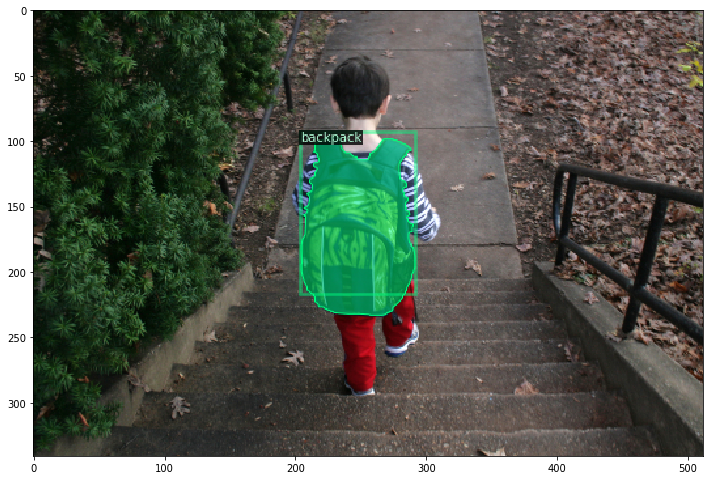

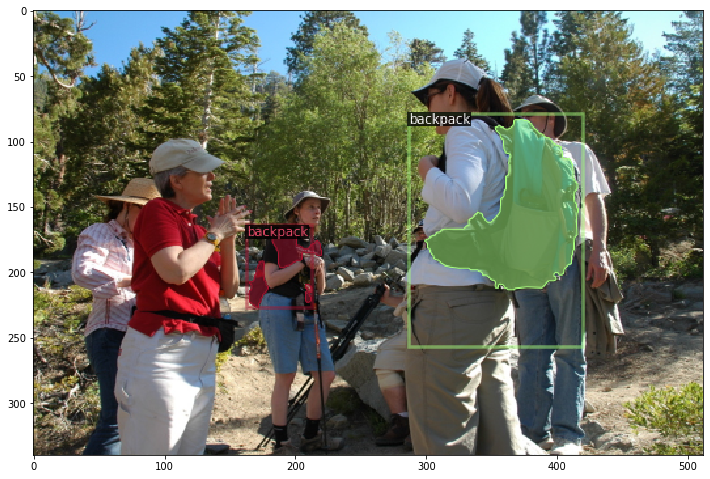

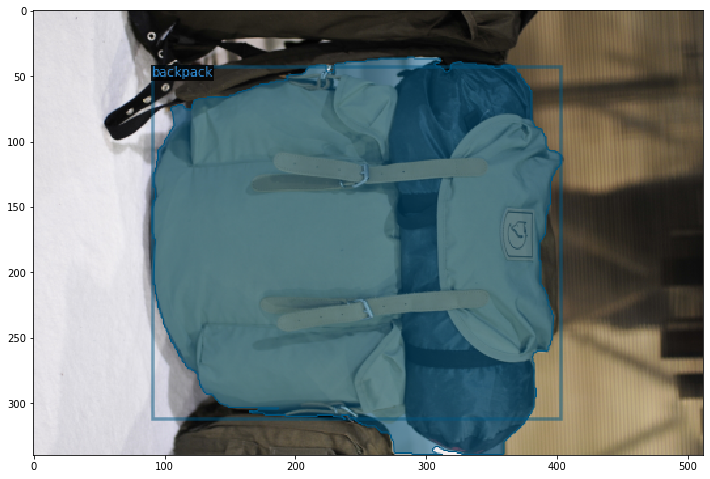

In [28]:
backpack_train_metadata = MetadataCatalog.get(train_data_name)

dataset_dicts = DatasetCatalog.get(name=train_data_name)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=backpack_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## <font style="color:green">4.3. Set Config and Import model files</font>

Get default configuration of detectron2 and update parameters according to our requirements.

Get more details of the configuration <a  href="https://detectron2.readthedocs.io/modules/config.html#">here</a>.

In [29]:
#Initialize with default configuration
cfg = get_cfg()

# update configuration with MaskRCNN configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Let's replace the detectron2 default train dataset with our train dataset.
cfg.DATASETS.TRAIN = (train_data_name,)

# No metric implemented for the test dataset, we will have to update cfg.DATASET.TEST with empty tuple
cfg.DATASETS.TEST = ()

# data loader configuration
cfg.DATALOADER.NUM_WORKERS = 2

# Update model URL in detectron2 config file
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

# batch size
cfg.SOLVER.IMS_PER_BATCH = 2

# choose a good learning rate
cfg.SOLVER.BASE_LR = 0.0005

# We need to specify the number of iteration for training in detectron2, not the number of epochs.
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# number of output class
# we have only one class that is Backpack
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

## <font style="color:green">4.4. Training</font>

Now, let's fine-tune a coco-pretrained Mask RCNN R50 FPN model on the backpack dataset.

detectron2.engine.defaults.DefaultTrainer(cfg)
A trainer with default training logic. Compared to SimpleTrainer, it contains the following logic in addition:

- Create model, optimizer, scheduler, dataloader from the given config.
- Load a checkpoint or cfg.MODEL.WEIGHTS, if exists, when resume_or_load is called.
- Register a few common hooks

Get more details <a href="https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultTrainer">here</a>.

In [30]:
# update create ouptput directory 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Before starting the training, let's set up the TensorBoard.

In [31]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

# if resume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

# start training
trainer.train()

[05/15 12:20:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[05/15 12:20:16 d2.engine.train_loop]: Starting training from iteration 0
[05/15 12:20:22 d2.utils.events]:  eta: 0:02:15  iter: 19  total_loss: 2.150  loss_cls: 0.742  loss_box_reg: 0.667  loss_mask: 0.692  loss_rpn_cls: 0.019  loss_rpn_loc: 0.008  time: 0.2780  data_time: 0.0168  lr: 0.000010  max_mem: 2709M
[05/15 12:20:28 d2.utils.events]:  eta: 0:02:06  iter: 39  total_loss: 1.931  loss_cls: 0.659  loss_box_reg: 0.553  loss_mask: 0.674  loss_rpn_cls: 0.014  loss_rpn_loc: 0.008  time: 0.2749  data_time: 0.0043  lr: 0.000020  max_mem: 2709M
[05/15 12:20:33 d2.utils.events]:  eta: 0:02:04  iter: 59  total_loss: 1.924  loss_cls: 0.548  loss_box_reg: 0.673  loss_mask: 0.653  loss_rpn_cls: 0.016  loss_rpn_loc: 0.011  time: 0.2801  data_time: 0.0043  lr: 0.000030  max_mem: 2709M
[05/15 12:20:39 d2.utils.events]:  eta: 0:01:59  iter: 79  total_loss: 1.746  loss_cls: 0.440  loss_box_reg: 0.652  loss_mask: 0.623  loss_rpn_cls: 0.019  loss_rpn_loc: 0.011  time: 0.2824  data_time: 0.0044  lr:

# <font style="color:green">5. Inference using the trained model</font>

Now, let's run inference with the trained model on the backpack test dataset. First, let's create a predictor using the model we just trained.

detectron2.engine.defaults.DefaultPredictor(cfg)
Create a simple end-to-end predictor with the given config that runs on single device for a single input image. Compared to using the model directly, this class does the following additions:

- Load checkpoint from cfg.MODEL.WEIGHTS.
- Always take BGR image as the input and apply conversion defined by cfg.INPUT.FORMAT.
- Apply resizing defined by cfg.INPUT.{MIN,MAX}_SIZE_TEST.
- Take one input image and produce a single output, instead of a batch.

Get more details <a href="https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultPredictor">here</a>.

In [32]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9


cfg.DATASETS.TEST = (val_data_name,)

backpack_test_metadata = MetadataCatalog.get(val_data_name)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prediction on a single image
predictor = DefaultPredictor(cfg)

WARNING [05/15 12:22:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/15 12:22:46 d2.data.datasets.coco]: Loaded 33 images in COCO format from data/validation.json
data/backpack-images/1209e7ce038f6790.jpg


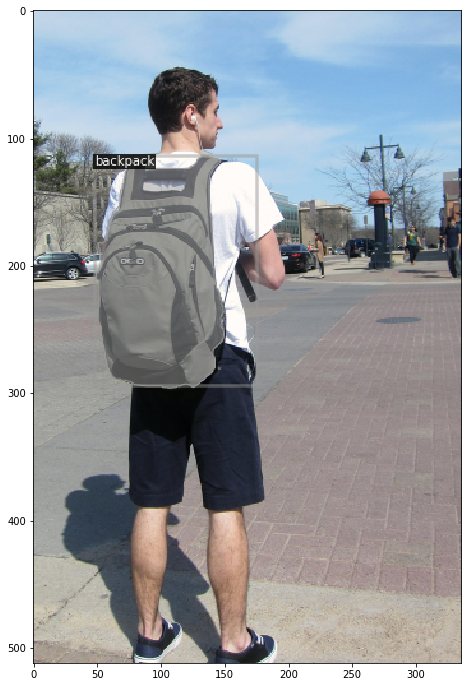

data/backpack-images/1d92dc7cdce8e9b3.jpg


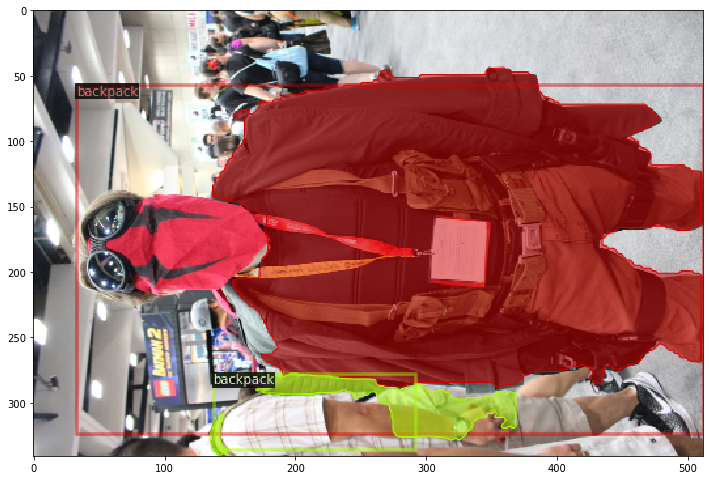

data/backpack-images/02c8e4cf17eecd02.jpg


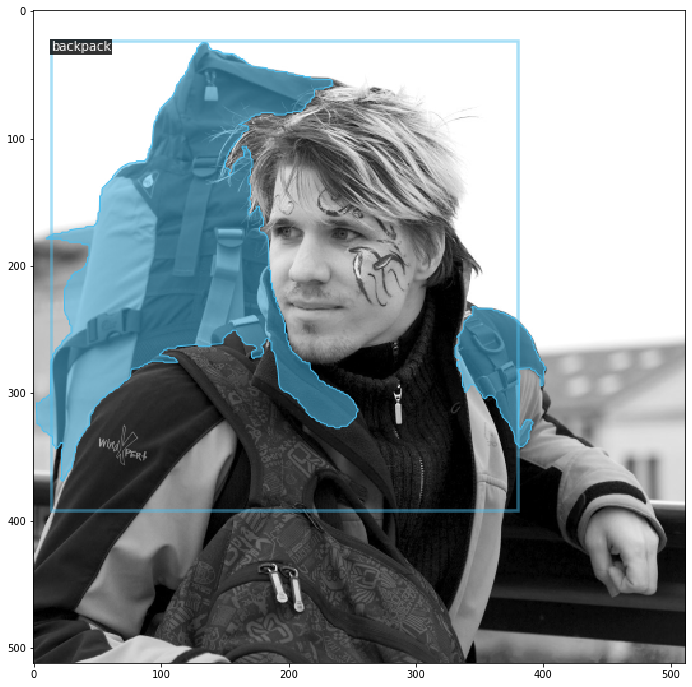

In [33]:
# let's have a look at prediction
test_dataset_dicts = DatasetCatalog.get(val_data_name)

for d in random.sample(test_dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=backpack_test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(outputs["instances"].to("cpu"))
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

# <font style="color:green">6. Inference on Video</font>

Lets run inference on a small surveillance video using our trained model.

**[Download the input video.](https://www.dropbox.com/s/0yx6lyxxg37cq8i/videoplayback_short.mp4?dl=0)**

In [34]:
def inference_on_video(video_path, out_video_path):
    cap = cv2.VideoCapture(video_path)
    cnt = 0

    output_frames = []

    while True:
        ret, im = cap.read()

        if not ret:
            break

        if cnt%5 == 0:
            outputs = predictor(im)
            v = Visualizer(im[:, :, ::-1],
                           metadata=backpack_test_metadata, 
                           scale=0.8, 
#                            instance_mode=ColorMode.IMAGE_BW
                          )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            output_frames.append(v.get_image()[:, :, ::-1])

        cnt = cnt + 1

    height, width, _ = output_frames[0].shape
    size = (width,height)
    out = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 10, size)

    for i in range(len(output_frames)):
        out.write(output_frames[i])

    out.release()

In [35]:
#Output video is stored as out.mp4 with backpack segmentations

inference_on_video('videoplayback_short.mp4', 'videoplayback_short_out.mp4')